# H2o Random Forest Model

## Version 1 Select Features from Exploratory Analysis Steps:
1. Exploratory analysis to select the most relavent features to build model
2. Clean up unused features from the H2o dataframe
3. Build random forest model

## Version 2 Select Features from Random Forest with Variable Importance Steps:
1. Run random forest model 
2. Find the top 3 or 4 relevant features with variable importance table



 # Introduction
 This tutorial shows how H2O [Gradient Boosted Models]
(https://en.wikipedia.org/wiki/Gradient_boosting) 
 and [Random Forest](https://en.wikipedia.org/wiki/Random_forest) models 
 can be used to do supervised classification and regression. 
 This tutorial covers usage of H2O from Python.
 An R version of this tutorial will be available as well in a separate document. 
 This file is available in plain R, R markdown, regular markdown, plain Python and iPython Notebook formats. 
 More examples and explanations can be found in 
 our [H2O GBM booklet](http://h2o.ai/resources/) and on our [H2O Github Repository](http://github.com/h2oai/h2o-3/).
 

 ## Task: Predicting forest cover type from cartographic variables only
 
 The actual forest cover type for a given observation (30 x 30 meter cell) was determined 
 from the US Forest Service (USFS). We are using the UC Irvine Covertype dataset.

 ### H2O Python Module
 
 Load the H2O Python module.

In [44]:
import h2o
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline 

# ### Start H2O
# Start up a 1-node H2O cloud on your local machine, and allow it to use all CPU cores and up to 2GB of memory:

h2o.init(max_mem_size = "2G")             #specify max number of bytes. uses all cores by default.
h2o.remove_all()                          #clean slate, in case cluster was already running


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,18 mins 58 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_keng_zrmedz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.614 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
# help(H2OGradientBoostingEstimator)


In [67]:
h2o.import_file


# ## H2O GBM and RF
# 
# While H2O Gradient Boosting Models and H2O Random Forest have many flexible parameters options, 
# they were designed to be just as easy to use as the other supervised training methods in H2O. 
# Early stopping, automatic data standardization and handling of categorical variables 
# and missing values and adaptive learning rates (per weight) reduce the amount of parameters the user has to specify.
# Often, it's just the number and sizes of hidden layers, 
# the number of epochs and the activation function and maybe some regularization techniques. 

# ### Getting started
# 
# We begin by importing our data into H2OFrames, which operate similarly in function to pandas DataFrames 
#but exist on the H2O cloud itself.  
# 
# In this case, the H2O cluster is running on our laptops.
# Data files are imported by their relative locations to this notebook.



covtype_df = h2o.import_file(os.path.realpath("../RH/covtype.full.csv"))




Parse progress: |█████████████████████████████████████████████████████████| 100%


# Exploratory Analysis

In [39]:
df = pd.read_csv('covtype.full.csv')

In [40]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,3066,124,5,0,0,1533,229,236,141,459,area_0,type_22,class_1
1,3136,32,20,450,-38,1290,211,193,111,1112,area_0,type_28,class_1
2,2655,28,14,42,8,1890,214,209,128,1001,area_2,type_9,class_2
3,3191,45,19,323,88,3932,221,195,100,2919,area_0,type_39,class_2
4,3217,80,13,30,1,3901,237,217,109,2859,area_0,type_22,class_7


In [41]:
# clean up spaces before and after strings
new_cal = []
for col in df.columns:
    new_cal.append(col.strip())
df.columns = new_cal

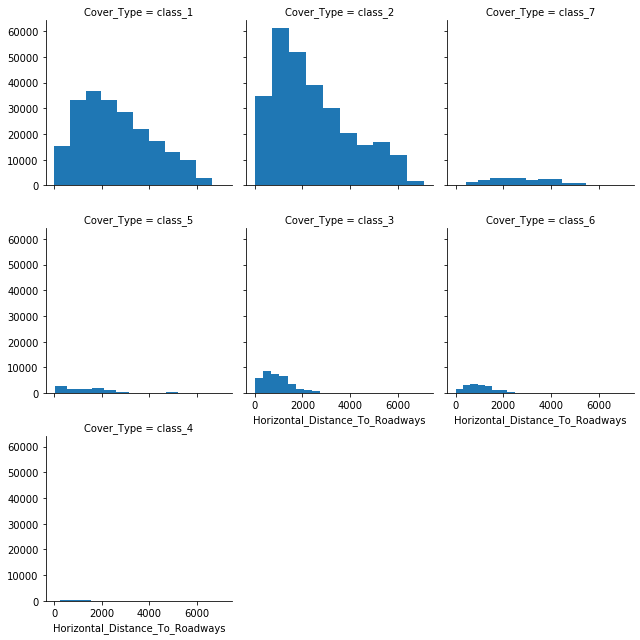

In [51]:
g = sb.FacetGrid(df, col = 'Cover_Type', col_wrap = 3)
g.map(plt.hist,'Horizontal_Distance_To_Roadways')
# plt.boxplot(x = df['Horizontal_Distance_To_Fire_Points']);

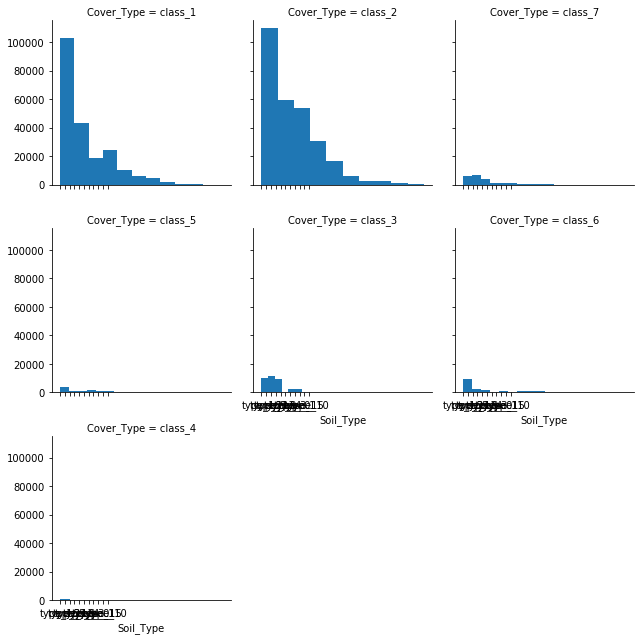

In [101]:
g = sb.FacetGrid(df, col = 'Cover_Type', col_wrap = 3)
g.map(plt.hist,'Soil_Type')

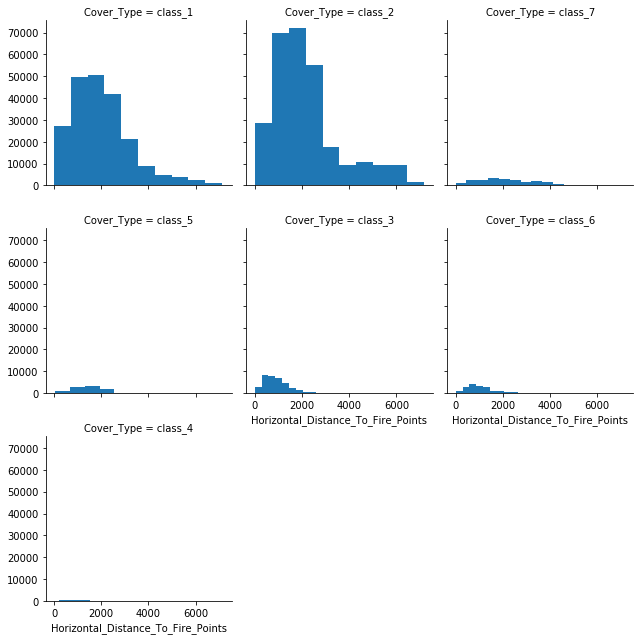

In [102]:
g = sb.FacetGrid(df, col = 'Cover_Type', col_wrap = 3)
g.map(plt.hist,'Horizontal_Distance_To_Fire_Points')

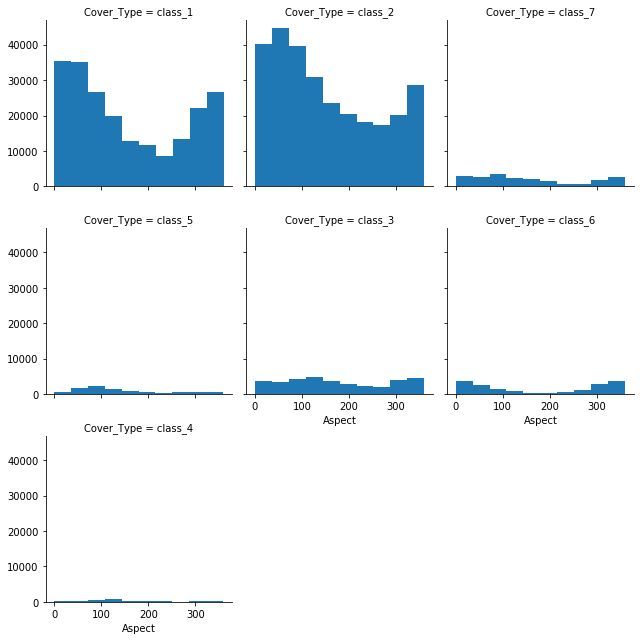

In [54]:
g = sb.FacetGrid(df, col = 'Cover_Type', col_wrap = 3)
g.map(plt.hist,'Aspect')

# Version 1 Select Features with Exploratory Analysis
### The First Random Forest
 We build our first model with the following parameters
 
 **model_id:** Not required, but allows us to easily find our model in the [Flow](http://localhost:54321/) interface  
 **ntrees:** Maximum number of trees used by the random forest. Default value is 50. 
 We can afford to increase this, as our early-stopping criterion will decide 
 when the random forest is sufficiently accurate.  
 **stopping_rounds:** Stopping criterion described above. 
 Stops fitting new trees when 2-tree rolling average is within 0.001 (default) of the two prior rolling averages. 
 Can be thought of as a convergence setting.  
 **score_each_iteration:** predict against training and validation for each tree. Default will skip several.  
 **seed:** set the randomization seed so we can reproduce results
 


In [68]:
# We import the full covertype dataset (581k rows, 13 columns, 10 numerical, 3 categorical) 
# and then split the data 3 ways:  
#   
# 60% for training  
# 20% for validation (hyper parameter tuning)  
# 20% for final testing  
# 
#  We will train a data set on one set and use the others to test the validity of the model by ensuring 
# that it can predict accurately on data the model has not been shown.  
#  
#  The second set will be used for validation most of the time.  
#  
#  The third set will be withheld until the end, to ensure that our validation accuracy is consistent 
# with data we have never seen during the iterative process. 

# In[ ]:

#split the data as described above
sub_df = covtype_df[:, ['Aspect','Elevation','Slope','Horizontal_Distance_To_Roadways','Cover_Type']]

In [70]:
train, valid, test = sub_df.split_frame([0.6, 0.2], seed=1234)

In [71]:
train.shape, valid.shape, test.shape

((349015, 5), (116018, 5), (115979, 5))

In [72]:


#Prepare predictors and response columns
covtype_X = ['Aspect','Elevation','Slope','Horizontal_Distance_To_Roadways']    #last column is Cover_Type, our desired response variable 
covtype_y = covtype_df.col_names[-1]    

covtype_X, covtype_y

(['Aspect', 'Elevation', 'Slope', 'Horizontal_Distance_To_Roadways'],
 'Cover_Type')

In [73]:

rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [74]:
rf_v1.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [87]:
vi = pd.DataFrame(rf_v1.varimp())
vi

,0,1,2,3
0,Elevation,4287542.500,1.000000,0.508903
1,Horizontal_Distance_To_Roadways,1897499.125,0.442561,0.225221
2,Aspect,1335670.250,0.311524,0.158535
3,Slope,904350.375,0.210925,0.107340


In [75]:
rf_v1.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2020-05-10 15:33:11,0.011 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-05-10 15:33:12,1.423 sec,1.0,0.485233,5.865008,0.269911,0.485653,5.868055,0.274199
2,,2020-05-10 15:33:13,2.617 sec,2.0,0.470818,5.106029,0.260316,0.418925,2.633924,0.226861
3,,2020-05-10 15:33:15,3.971 sec,3.0,0.458874,4.542683,0.250106,0.398934,1.676427,0.209485
4,,2020-05-10 15:33:16,5.398 sec,4.0,0.446072,3.937092,0.240813,0.389751,1.217296,0.201624
...,...,...,...,...,...,...,...,...,...,...
66,,2020-05-10 15:39:15,6 min 4.219 sec,66.0,0.371176,0.505061,0.182365,0.369242,0.447003,0.180662
67,,2020-05-10 15:39:25,6 min 14.384 sec,67.0,0.371091,0.502749,0.182161,0.369195,0.446608,0.180713
68,,2020-05-10 15:39:37,6 min 26.097 sec,68.0,0.371078,0.501159,0.182115,0.369229,0.446417,0.180532
69,,2020-05-10 15:39:49,6 min 37.958 sec,69.0,0.371001,0.500063,0.182138,0.369180,0.446279,0.180524


In [76]:
rf_v1.hit_ratio_table(valid=True)


Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.819675
1,2,0.984787
2,3,0.997845
3,4,0.999190
4,5,0.999345
5,6,0.999345
6,7,1.000000


 ### Now for GBM 
 First we will use all default settings, then make some changes to improve our predictions.

In [77]:
gbm_v1 = H2OGradientBoostingEstimator(
    model_id="gbm_covType_v1",
    seed=2000000
)
gbm_v1.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [78]:
# Model performance
performance = gbm_v1.model_performance(test_data=test)

print(performance)


ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.20755019064315547
RMSE: 0.45557676701424915
LogLoss: 0.6297406991664978
Mean Per-Class Error: 0.4738026857639207

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
0,29605.0,12095.0,23.0,0.0,6.0,8.0,483.0,0.298792,"12,615 / 42,220"
1,9918.0,45737.0,592.0,0.0,78.0,210.0,44.0,0.191626,"10,842 / 56,579"
2,0.0,1570.0,5075.0,96.0,0.0,428.0,0.0,0.292091,"2,094 / 7,169"
3,0.0,1.0,253.0,258.0,0.0,15.0,0.0,0.510436,269 / 527
4,5.0,1550.0,15.0,0.0,333.0,0.0,0.0,0.825013,"1,570 / 1,903"
5,0.0,959.0,1371.0,34.0,0.0,1106.0,0.0,0.681268,"2,364 / 3,470"
6,2084.0,43.0,0.0,0.0,0.0,0.0,1984.0,0.517392,"2,127 / 4,111"
7,41612.0,61955.0,7329.0,388.0,417.0,1767.0,2511.0,0.274886,"31,881 / 115,979"



Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.725114
1,2,0.966925
2,3,0.994447
3,4,0.998965
4,5,0.999957
5,6,1.000000
6,7,1.000000


In [79]:
gbm_v1.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2020-05-10 15:42:22,0.004 sec,0.0,0.857143,1.945910,0.623509,0.857143,1.945910,0.624274
1,,2020-05-10 15:42:22,0.615 sec,1.0,0.808480,1.661211,0.300600,0.808647,1.662167,0.303970
2,,2020-05-10 15:42:23,1.308 sec,2.0,0.766584,1.474716,0.298368,0.766901,1.476291,0.301238
3,,2020-05-10 15:42:24,1.853 sec,3.0,0.729736,1.337862,0.298936,0.730203,1.339941,0.302212
4,,2020-05-10 15:42:24,2.395 sec,4.0,0.696992,1.230599,0.298609,0.697620,1.233143,0.301617
5,,2020-05-10 15:42:25,2.927 sec,5.0,0.668284,1.145505,0.297039,0.669022,1.148308,0.300014
6,,2020-05-10 15:42:25,3.454 sec,6.0,0.642988,1.075963,0.296116,0.643863,1.079107,0.298678
7,,2020-05-10 15:42:26,3.988 sec,7.0,0.620885,1.018516,0.295967,0.621925,1.022081,0.298919
8,,2020-05-10 15:42:30,7.991 sec,17.0,0.507993,0.752595,0.284885,0.510022,0.758509,0.287611
9,,2020-05-10 15:42:37,15.182 sec,32.0,0.466658,0.655971,0.276590,0.469351,0.663662,0.279431


In [80]:
gbm_v1.hit_ratio_table(valid=True)


Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.725689
1,2,0.966557
2,3,0.994561
3,4,0.998759
4,5,0.999991
5,6,1.000000
6,7,1.000000


# Version 2 Select Features with Random Forest 


In [90]:
train, valid, test = covtype_df.split_frame([0.6, 0.2], seed=1234)
#Prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]     #last column is Cover_Type, our desired response variable 
covtype_y = covtype_df.col_names[-1]   

In [91]:
train.shape, valid.shape, test.shape

((349015, 13), (116018, 13), (115979, 13))

In [92]:
covtype_X, covtype_y

(['Elevation',
  'Aspect',
  'Slope',
  'Horizontal_Distance_To_Hydrology',
  'Vertical_Distance_To_Hydrology',
  'Horizontal_Distance_To_Roadways',
  'Hillshade_9am',
  'Hillshade_Noon',
  'Hillshade_3pm',
  'Horizontal_Distance_To_Fire_Points',
  'Wilderness_Area',
  'Soil_Type'],
 'Cover_Type')

In [96]:
# ### Parity
# 
# Now the GBM is close to the initial random forest.
# 
# However, we used a default random forest. 
# Random forest's primary strength is how well it runs with standard parameters, 
# and while there are only a few parameters to tune, we can experiment with those to see if it will make a difference.  
# 
# The main parameters to tune are the tree depth and the mtries, which is the number of predictors to use.  
# 
# The default depth of trees is 20. 
# It is common to increase this number, to the point that in some implementations, the depth is unlimited. 
# We will increase ours from 20 to 30.  
# 
# Note that the default mtries depends on whether classification or regression is being run. 
# The default for classification is one-third of the columns.
# The default for regression is the square root of the number of columns.  

# ### Random Forest #2
rf_v2 = H2ORandomForestEstimator(
    model_id="rf_covType_v2",
#     ntrees=200,
    max_depth=30,
    stopping_rounds=2,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000)
rf_v2.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [97]:
# Model performance
performance = rf_v2.model_performance(test_data=test)

print(performance)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.03986601390804113
RMSE: 0.199664753795058
LogLoss: 0.16349892382021367
Mean Per-Class Error: 0.08095207895930744

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
0,40087.0,2013.0,1.0,0.0,18.0,4.0,97.0,0.050521,"2,133 / 42,220"
1,1278.0,55033.0,78.0,0.0,99.0,70.0,21.0,0.027325,"1,546 / 56,579"
2,15.0,109.0,6898.0,31.0,6.0,110.0,0.0,0.037802,"271 / 7,169"
3,2.0,4.0,52.0,457.0,0.0,12.0,0.0,0.132827,70 / 527
4,40.0,274.0,19.0,0.0,1561.0,9.0,0.0,0.179716,"342 / 1,903"
5,18.0,89.0,185.0,14.0,4.0,3160.0,0.0,0.089337,"310 / 3,470"
6,181.0,19.0,0.0,0.0,2.0,0.0,3909.0,0.049136,"202 / 4,111"
7,41621.0,57541.0,7233.0,502.0,1690.0,3365.0,4027.0,0.042025,"4,874 / 115,979"



Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.957975
1,2,0.997077
2,3,0.998319
3,4,0.998379
4,5,0.998396
5,6,0.998396
6,7,1.000000


In [98]:
vi_2 = pd.DataFrame(rf_v2.varimp())
vi_2

,0,1,2,3
0,Elevation,807548.750000,1.000000,0.250595
1,Soil_Type,679146.875000,0.840998,0.210750
2,Horizontal_Distance_To_Roadways,364836.093750,0.451782,0.113214
3,Horizontal_Distance_To_Fire_Points,343291.906250,0.425104,0.106529
4,Horizontal_Distance_To_Hydrology,179493.968750,0.222270,0.055700
5,Vertical_Distance_To_Hydrology,158505.156250,0.196279,0.049187
6,Wilderness_Area,141778.453125,0.175566,0.043996
7,Aspect,123543.710938,0.152986,0.038338
8,Hillshade_Noon,116247.976562,0.143952,0.036074
9,Hillshade_9am,110365.023438,0.136667,0.034248


In [99]:
rf_v2.hit_ratio_table(valid=True)
# ### Final Predictions
# 
# Now that we have our validation accuracy up beyond 95%, we can start considering our test data.  
# We have withheld an extra test set to ensure that after all the parameter tuning we have repeatedly applied with the validation data, we still have a completely pristine data set upon which to test the predictive capacity of our model.




Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.957938
1,2,0.997130
2,3,0.998492
3,4,0.998526
4,5,0.998535
5,6,0.998535
6,7,1.000000


 This default GBM is much worse than our original random forest.  
 
 
 The GBM is far from converging, so there are three primary knobs to adjust to get our performance up 
 if we want to keep a similar run time.  
 
 1: Adding trees will help. The default is 50.  
 2: Increasing the learning rate will also help. 
 The contribution of each tree will be stronger, so the model will move further away from the overall mean.  
 3: Increasing the depth will help. 
 This is the parameter that is the least straightforward. 
 Tuning trees and learning rate both have direct impact that is easy to understand. 
 Changing the depth means you are adjusting the "weakness" of each learner.
 Adding depth makes each tree fit the data closer.  
   
 The first configuration will attack depth the most, 
 since we've seen the random forest focus on a continuous variable (elevation) 
 and 40-class factor (soil type) the most.  
 
 Also we will take a look at how to review a model while it is running.  
 ### GBM Round 2
 
 Let's do the following:
 
 1. decrease the number of trees to speed up runtime(from default 50 to 20)
 2. increase the learning rate (from default 0.1 to 0.2)
 3. increase the depth (from default 5 to 10)

In [93]:
gbm_v2 = H2OGradientBoostingEstimator(
    ntrees=20,
    learn_rate=0.2,
    max_depth=10,
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    stopping_rounds=2,
    score_each_iteration=True,
    model_id="gbm_covType_v2",
    seed=2000000
)
gbm_v2.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [40]:
# ### Live Performance Monitoring
# 
# While this is running, we can actually look at the model. To do this we simply need a new connection to H2O. 
# 
# This Python notebook will run the model, so we need either another notebook or the web browser (or R, etc.). 
# In this demo, we will use [Flow](http://localhost:54321) in our web browser http://localhost:54321 
# and the focus will be to look at model performance, since we are using Python to control H2O. 

# In[ ]:

gbm_v2.hit_ratio_table(valid=True)


# This has moved us in the right direction, but still lower accuracy than the random forest.  
# 
# It still has yet to converge, so we can make it more aggressive.  
# 
# We can now add the stochastic nature of random forest into the GBM using some of the new H2O settings. 
# This will help generalize and also provide a quicker runtime, so we can add a few more trees.




Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.917685
1,2,0.996932
2,3,0.999853
3,4,0.999983
4,5,1.000000
5,6,1.000000
6,7,1.000000


In [41]:
# ### GBM: Third Time is the Charm
# 
# 1. Add a few trees(from 20 to 30)
# 2. Increase learning rate (to 0.3)
# 3. Use a random 70% of rows to fit each tree
# 4. Use a random 70% of columns to fit each tree

gbm_v3 = H2OGradientBoostingEstimator(
    ntrees=30,
    learn_rate=0.3,
    max_depth=10,
    sample_rate=0.7,
    col_sample_rate=0.7,
    stopping_rounds=2,
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    score_each_iteration=True,
    model_id="gbm_covType_v3",
    seed=2000000
)
gbm_v3.train(covtype_X, covtype_y, training_frame=train, validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [44]:
gbm_v3.hit_ratio_table(valid=True)


Top-7 Hit Ratios: 


,k,hit_ratio
0,1,0.943164
1,2,0.997725
2,3,0.999828
3,4,0.999983
4,5,0.999983
5,6,0.999983
6,7,1.000000


In [57]:
h2o.shutdown(prompt=False)


# ### Possible Further Steps
# 
# Model-agnostic gains can be found in improving handling of categorical features. 
# We could experiment with the nbins and nbins_cats settings to control the H2O splitting.
# The general guidance is to lower the number to increase generalization (avoid overfitting), 
# increase to better fit the distribution.  
#  
# A good example of adjusting this value is for nbins_cats 
# to be increased to match the number of values in a category. 
# Though usually unnecessary, this can improve performance if a problem has a very important categorical predictor.  
# 
# 
# With regards to our Random Forest, we could further experiment with deeper trees 
# or a higher percentage of columns used (mtries).  
# 
# The GBM can be set to converge a slower for optimal accuracy. 
# If we were to relax our runtime requirements a little bit, we could balance the learn rate and number of trees used.  
# 
# In a production setting where fine-grain accuracy is beneficial, 
# it is common to set the learn rate to a very small number, such as 0.01 or smaller, and add trees to match.  
# 
# Use of early stopping is very powerful in allowing the setting of a low learning rate and the building 
# as many trees as needed until the desired convergence is met.
# 
# ### More information can be found in the [H2O Gradient Boosted Models booklet]
# (http://h2o.ai/resources/), in our [H2O SlideShare Presentations](http://www.slideshare.net/0xdata/presentations), 
# our [H2O YouTube channel](https://www.youtube.com/user/0xdata/), 
# as well as on our [H2O Github Repository](https://github.com/h2oai/h2o-3/), 
# especially in our [H2O GBM R tests](https://github.com/h2oai/h2o-3/tree/master/h2o-r/tests/testdir_algos/gbm), 
# and [H2O GBM Python tests](https://github.com/h2oai/h2o-3/tree/master/h2o-py/tests/testdir_algos/gbm).


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.


H2O session _sid_a501 closed.
